In [27]:
import json
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
import scipy.signal as signal
import statistics



In [18]:
def load_json(group,student):
    with open(f'./data/all_json/{group}_{student}.json') as f:
        return json.load(f)
    
def load_images(group,student):
    images =  imageio.imread(f'./data/sequences/{group}-{student}.tif')
    return np.mean(images,axis=3)


def show_image(group,student,frame):
    plt.figure(figsize=(15,10))
    data = load_json(group,student)
    images = load_images(group,student)
    plt.imshow(images[frame-1], cmap='gray')
    plt.title(f'{group}-{student} frame {frame}')
    data = data['{}_{}_frame_{}'.format(group,student,frame)]
    for d in data["boxes"]:
        rect = plt.Rectangle((d[0], d[1]), d[2], d[3], fill=False, color='red')
        plt.gca().add_patch(rect)
    
    for d in data["cells"]:
        plt.plot(d[0], d[1], 'ro', markersize=2) 
    plt.show()

In [16]:
frame_number = 29
threshold = 0.2
group = 1
student = 1

In [4]:
data = load_json(group,student)
images = load_images(group,student)

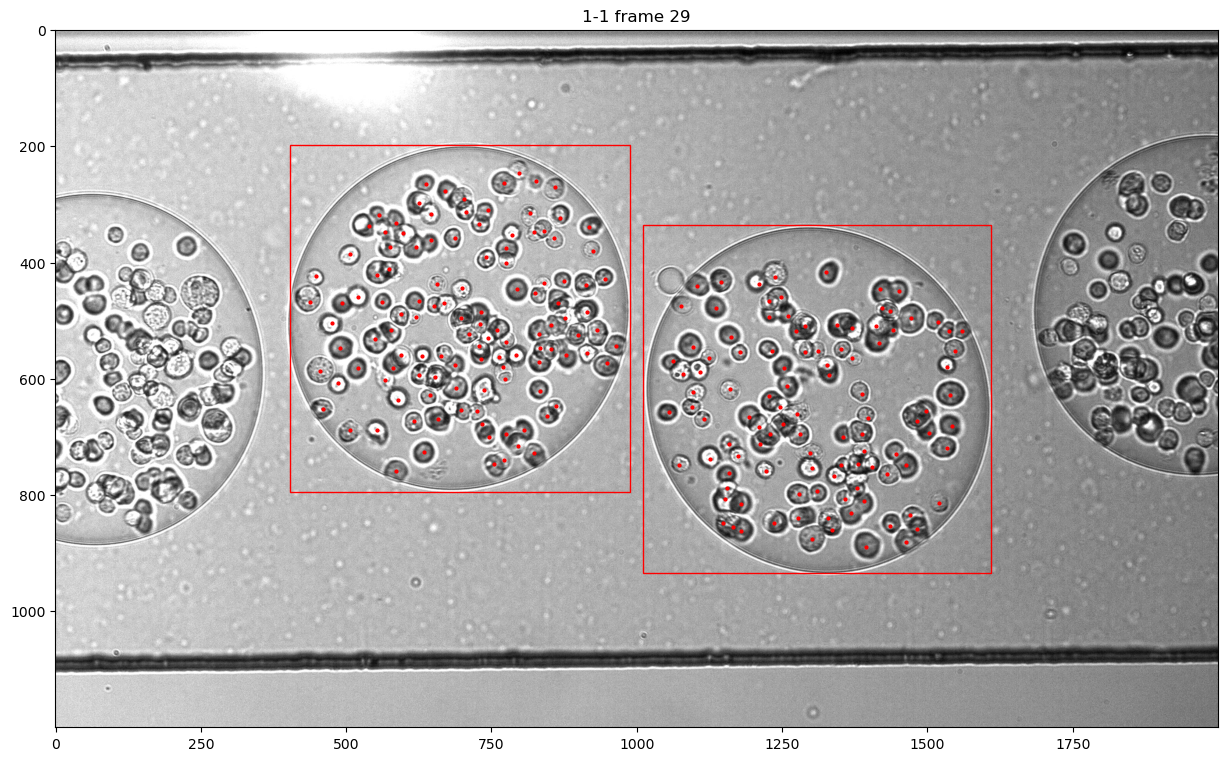

In [19]:
show_image(group,student,frame_number)  

## Background definition

In [7]:
def back_mean(images, nb_frames=60):
    background = np.mean(images[:nb_frames],axis=(0))
    return background


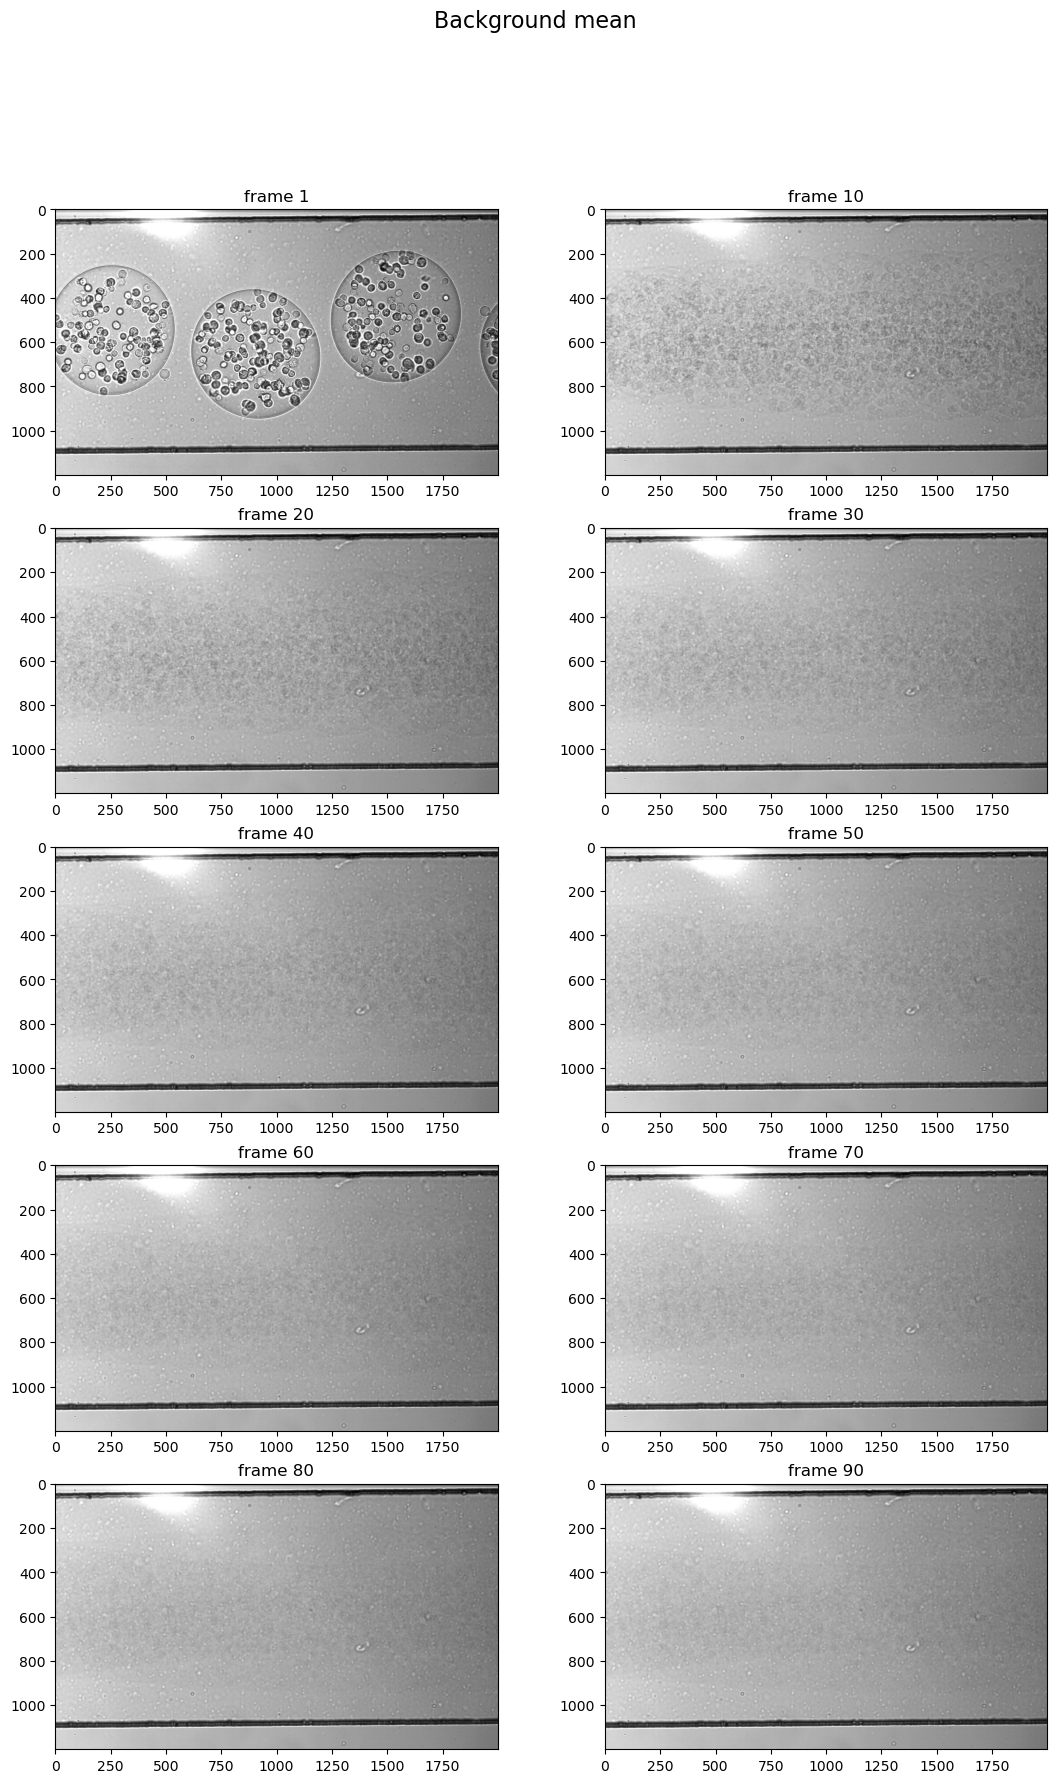

In [20]:
fig, axs = plt.subplots(5,2, figsize=(13,20))
fig.suptitle('Background mean', fontsize=16)
axs[0,0].imshow(back_mean(images,1), cmap='gray')
axs[0,0].set_title(f'frame {1}')
for i in range(1,10):
    axs[i//2,i%2].imshow(back_mean(images, i*10), cmap='gray')
    axs[i//2,i%2].set_title(f'frame {i*10}')
plt.show()

In [22]:
def column_energy_one(column):
    return np.sum(np.diff(column)**2)

def column_energy_integrated(column, previous = 1):
    energy = 0
    for i in range(previous):
        rolling = np.roll(column, 1)
        energy += np.sum(np.subtract(column,rolling)**2)
    return energy

def column_energy_var(column):
    return statistics.variance(column)

In [23]:
nb_samples = 100
square_diff = []
indexes_square = []
images_sample = images[:nb_samples]
for index, image in enumerate(images_sample):
    for col in range(image.shape[1]):
        energy = column_energy_one(image[:,col])
        if index == 0:
            square_diff.append(energy)
            indexes_square.append(0)
        else:
            if square_diff[col] > energy:
                square_diff[col] = energy
                indexes_square[col] = index

In [24]:
# Background creation
background_energy = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_energy.shape)[0]):
    for j in range((background_energy.shape)[1]):
        background_energy[i][j][:] = images_sample[indexes_square[j],i,j]

In [28]:
# Variance of each column
nb_samples = 10
var_diff = []
indexes_var = []
images_sample = images[0:nb_samples]
for index, image in enumerate(images_sample):
    for col in range(image.shape[1]):
        var = column_energy_var(image[:,col])
        if index == 0:
            var_diff.append(var)
            indexes_var.append(0)
        else:
            if var_diff[col] < var:
                var_diff[col] = var
                indexes_var[col] = index

In [29]:
# Background creation
background_var = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_var.shape)[0]):
    for j in range((background_var.shape)[1]):
        background_var[i][j][:] = images_sample[indexes_var[j],i,j]

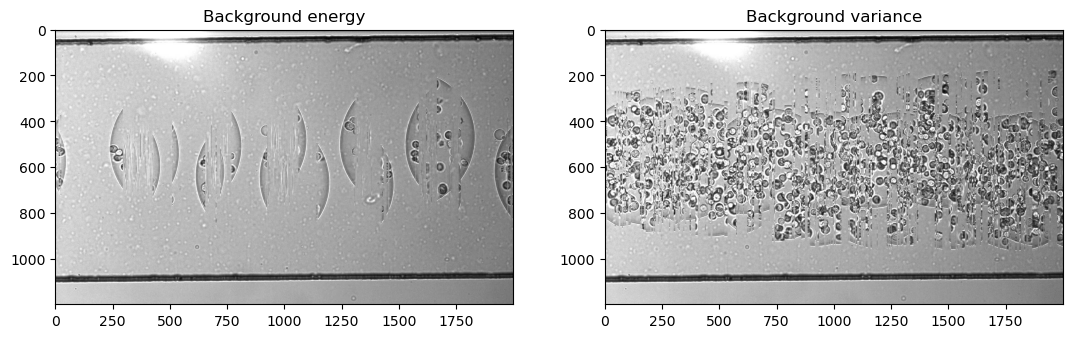

In [31]:
fig, axs = plt.subplots(1,2, figsize=(13,20))
axs[0].imshow(background_energy, cmap='gray')
axs[0].set_title('Background energy')
axs[1].imshow(background_var, cmap='gray')
axs[1].set_title('Background variance')

plt.show()